In [25]:
# # Colab 环境安装依赖（取消注释后运行）
!pip install torch torchvision
!pip install matplotlib numpy requests

# Transformer 从零到一：源代码实现 vs 简洁实现

基于论文 *Attention Is All You Need* (Vaswani et al., 2017)，
用 **英 → 法翻译** 任务演示 Transformer 的 Encoder-Decoder 架构。

本 Notebook 包含两种实现方式，使用 **相同的超参数和数据**，方便直接对比：

| | 实现 A — 源代码实现 | 实现 B — 简洁实现 |
|---|---|---|
| 核心思路 | 手写 Attention、FFN、Encoder、Decoder 每个组件 | 直接调用 `nn.Transformer` |
| 代码量 | ~200 行 | ~30 行 |
| 适合场景 | 深入理解原理 | 快速搭建模型 |
| 推理方式 | KV-cache 逐 token 解码 | 每步传入完整已生成序列 |

In [26]:
import math
import collections
import os
import re
import requests
import zipfile

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## 1. 数据准备

使用 Tatoeba 项目的 **英-法平行语料**（~190k 句对），取前 8000 条短句用于快速训练。

流程：下载 → 预处理 → 构建词表 → 转为 DataLoader。

In [27]:
import os
import requests
import zipfile

def download_nmt_data(data_dir='./nmt_data'):
    url = 'https://d2l-data.s3-accelerate.amazonaws.com/fra-eng.zip'
    os.makedirs(data_dir, exist_ok=True)
    zip_path = os.path.join(data_dir, 'fra-eng.zip')

    if not os.path.exists(zip_path):
        print('Downloading...')
        r = requests.get(url, timeout=120)
        r.raise_for_status()
        with open(zip_path, 'wb') as f:
            f.write(r.content)
        print('Download done.')

    with zipfile.ZipFile(zip_path) as z:
        z.extractall(data_dir)

    # 自动寻找 fra.txt
    for root, dirs, files in os.walk(data_dir):
        if 'fra.txt' in files:
            txt_path = os.path.join(root, 'fra.txt')
            break

    with open(txt_path, encoding='utf-8') as f:
        return f.read()

raw_text = download_nmt_data()
print(raw_text[:200])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !
Fire!	Au feu !
Help!	À l'aide !
Jump.	Saute.
Stop!	Ça suffit !
Stop!	Stop !
Stop!	Arrête-toi !
Wait!	Attends !
Wait!	Attendez


In [28]:
import re

def preprocess_nmt(text):
    text = text.lower().replace('\u202f', ' ').replace('\xa0', ' ')
    lines = text.strip().split('\n')
    pairs = []
    for line in lines:
        parts = line.split('\t')
        if len(parts) >= 2:
            src = re.sub(r'([.!?,:;"])', r' \1', parts[0])
            src = re.sub(r'\s+', ' ', src).strip()
            tgt = re.sub(r'([.!?,:;"])', r' \1', parts[1])
            tgt = re.sub(r'\s+', ' ', tgt).strip()
            pairs.append((src, tgt))
    return pairs

pairs = preprocess_nmt(raw_text)
pairs = pairs[:8000]
print(f'句对数量: {len(pairs)}')
print(f'示例: {pairs[0]}')

句对数量: 8000
示例: ('go .', 'va !')


### 1.1 词表（Vocabulary）

将文本中的单词映射为整数索引，同时维护 4 个特殊 token：

| Token | 含义 | 索引 |
|---|---|---|
| `<pad>` | 填充符，将不等长句子补齐到相同长度 | 0 |
| `<bos>` | 序列开始标记（Begin Of Sequence） | 1 |
| `<eos>` | 序列结束标记（End Of Sequence） | 2 |
| `<unk>` | 未登录词（词频 < min_freq 的词） | 3 |

In [29]:
class Vocab:
    """简单词表：word ↔ index 双向映射。"""
    PAD, BOS, EOS, UNK = '<pad>', '<bos>', '<eos>', '<unk>'
    SPECIAL = [PAD, BOS, EOS, UNK]

    def __init__(self, sentences, min_freq=2):
        # 统计所有句子中每个词的出现频率
        counter = collections.Counter(
            w for s in sentences for w in s.split())
        # 索引 0~3 留给特殊 token，之后是高频词
        self.idx_to_token = list(self.SPECIAL)
        self.idx_to_token += [
            t for t, f in counter.items() if f >= min_freq]
        self.token_to_idx = {
            t: i for i, t in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        """支持 vocab['hello'] 或 vocab[['hello', 'world']]。"""
        if isinstance(tokens, str):
            return self.token_to_idx.get(tokens, self.token_to_idx[self.UNK])
        return [self[t] for t in tokens]

    def to_tokens(self, indices):
        return [self.idx_to_token[i] for i in indices]

# 分别为源语言（英语）和目标语言（法语）构建词表
src_vocab = Vocab([s for s, _ in pairs], min_freq=2)
tgt_vocab = Vocab([t for _, t in pairs], min_freq=2)
print(f'源词表大小: {len(src_vocab)}, 目标词表大小: {len(tgt_vocab)}')

源词表大小: 1308, 目标词表大小: 1884


### 1.2 Dataset & DataLoader

将句对转为等长的整数序列（截断/填充至 `NUM_STEPS=10`），
同时记录每个句子的 **有效长度**（非填充部分），用于后续的 mask 计算。

In [30]:
NUM_STEPS = 10  # 固定序列长度

def tokenize_and_pad(sentence, vocab, num_steps):
    """分词 → 加 <eos> → 转索引 → 截断/填充到 num_steps。"""
    tokens = sentence.split() + [Vocab.EOS]
    indices = vocab[tokens]
    valid_len = len(indices)
    if len(indices) >= num_steps:
        indices = indices[:num_steps]
        valid_len = num_steps
    else:
        indices += [vocab[Vocab.PAD]] * (num_steps - len(indices))
    return indices, valid_len

class NMTDataset(Dataset):
    def __init__(self, pairs, src_vocab, tgt_vocab, num_steps):
        self.data = []
        for src, tgt in pairs:
            src_ids, src_len = tokenize_and_pad(src, src_vocab, num_steps)
            tgt_ids, tgt_len = tokenize_and_pad(tgt, tgt_vocab, num_steps)
            self.data.append((
                torch.tensor(src_ids), torch.tensor(src_len),
                torch.tensor(tgt_ids), torch.tensor(tgt_len)))

    def __len__(self): return len(self.data)
    def __getitem__(self, idx): return self.data[idx]

BATCH_SIZE = 64
dataset = NMTDataset(pairs, src_vocab, tgt_vocab, NUM_STEPS)
train_iter = DataLoader(dataset, BATCH_SIZE, shuffle=True, drop_last=True)

# 取一个 batch 验证形状
src_ids, src_len, tgt_ids, tgt_len = next(iter(train_iter))
print(f'src: {src_ids.shape}, tgt: {tgt_ids.shape}')
print(f'src_len 示例: {src_len[:5]}')

src: torch.Size([64, 10]), tgt: torch.Size([64, 10])
src_len 示例: tensor([5, 4, 4, 5, 5])


## 2. 共享组件

以下组件 **两种实现都会用到**：超参数、Positional Encoding、训练循环、推理函数。

In [31]:
# ── 超参数（两种实现保持一致，方便对比） ──
D_MODEL   = 32    # 词嵌入维度 / 模型宽度
D_FF      = 64    # FFN 隐藏层维度
NUM_HEADS = 4     # 注意力头数（D_MODEL 必须能被 NUM_HEADS 整除）
NUM_LAYERS = 2    # Encoder / Decoder 各堆叠几层
DROPOUT   = 0.1
LR        = 0.005
NUM_EPOCHS = 200

### 2.1 Positional Encoding（位置编码）

Transformer 没有 RNN 的时序结构，需要 **显式注入位置信息**。
论文使用正弦/余弦函数：

$$PE_{(pos, 2i)} = \sin\!\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

$$PE_{(pos, 2i+1)} = \cos\!\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

- $pos$：token 在序列中的位置（0, 1, 2, ...）
- $i$：嵌入维度的索引
- 不同频率的正弦波让模型能区分不同位置，且能泛化到训练时未见过的序列长度

In [32]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        # 预计算位置编码表：(max_len, d_model)
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)  # (max_len, 1)
        # 10000^(2i/d) 的倒数，用 exp-log 技巧计算
        div_term = torch.exp(
            torch.arange(0, d_model, 2, dtype=torch.float32)
            * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div_term)  # 偶数维：sin
        pe[:, 1::2] = torch.cos(pos * div_term)  # 奇数维：cos
        # 注册为 buffer（不参与梯度更新，但会随模型保存/迁移设备）
        self.register_buffer('pe', pe.unsqueeze(0))  # (1, max_len, d_model)

    def forward(self, X, offset=0):
        # X: (batch, seq_len, d_model)
        # offset: 已生成 token 数（KV-cache 推理时使用，训练时为 0）
        X = X + self.pe[:, offset:offset + X.shape[1], :]
        return self.dropout(X)

### 2.2 训练函数

两种实现共享同一训练循环。关键要求：模型的 `forward` 必须满足统一接口：

```python
logits, _ = net(src_ids, dec_input, src_valid_lens)
# logits: (batch, seq_len, vocab_size)
```

In [33]:
def train_model(net, train_iter, lr, num_epochs, tgt_vocab, device):
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    # ignore_index=PAD 让损失函数忽略填充位置
    loss_fn = nn.CrossEntropyLoss(
        ignore_index=tgt_vocab[Vocab.PAD], reduction='mean')
    losses = []

    for epoch in range(num_epochs):
        net.train()
        total_loss, total_tokens = 0.0, 0
        for src_ids, src_len, tgt_ids, tgt_len in train_iter:
            src_ids = src_ids.to(device)
            src_len = src_len.to(device)
            tgt_ids = tgt_ids.to(device)

            # Decoder 输入 = <bos> + target[:-1]（Teacher Forcing）
            bos = torch.full(
                (tgt_ids.shape[0], 1), tgt_vocab[Vocab.BOS],
                device=device, dtype=torch.long)
            dec_input = torch.cat([bos, tgt_ids[:, :-1]], dim=1)

            Y_hat, _ = net(src_ids, dec_input, src_len)
            loss = loss_fn(
                Y_hat.reshape(-1, Y_hat.shape[-1]),  # (batch*seq, vocab)
                tgt_ids.reshape(-1))                  # (batch*seq,)

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(net.parameters(), 1.0)  # 梯度裁剪
            optimizer.step()

            total_loss += loss.item() * tgt_ids.numel()
            total_tokens += tgt_ids.numel()

        avg_loss = total_loss / total_tokens
        losses.append(avg_loss)
        if (epoch + 1) % 20 == 0 or epoch == 0:
            print(f'Epoch {epoch+1:3d}, Loss: {avg_loss:.4f}')

    plt.figure(figsize=(6, 3))
    plt.plot(losses)
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.title('Training Loss'); plt.tight_layout(); plt.show()

### 2.3 推理（贪心解码）& BLEU 评估

**贪心解码**：每步选概率最高的 token，直到生成 `<eos>` 或达到最大长度。

**BLEU**（Bilingual Evaluation Understudy）：衡量机器翻译质量的标准指标，
通过比较生成序列与参考译文的 n-gram 重合度打分，范围 0~1。

In [34]:
def predict(net, src_sentence, src_vocab, tgt_vocab, num_steps, device):
    """贪心解码：自动区分源代码实现（KV-cache）和简洁实现（全序列）。"""
    net.eval()
    tokens = src_sentence.lower().split() + [Vocab.EOS]
    src_ids = torch.tensor(src_vocab[tokens], device=device).unsqueeze(0)
    src_len = torch.tensor([len(tokens)], device=device)
    output_tokens = []

    if isinstance(net, EncoderDecoder):
        # ── 源代码实现：利用 KV-cache，每步只输入 1 个 token ──
        with torch.no_grad():
            enc_out = net.encoder(src_ids, src_len)
        state = net.decoder.init_state(enc_out, src_len)
        dec_input = torch.tensor([[tgt_vocab[Vocab.BOS]]], device=device)
        for _ in range(num_steps):
            with torch.no_grad():
                Y, state = net.decoder(dec_input, state)
            token_id = Y.argmax(dim=-1)[:, -1:].item()
            if token_id == tgt_vocab[Vocab.EOS]: break
            output_tokens.append(tgt_vocab.idx_to_token[token_id])
            dec_input = torch.tensor([[token_id]], device=device)
    else:
        # ── 简洁实现：每步传入完整已生成序列 ──
        dec_ids = [tgt_vocab[Vocab.BOS]]
        for _ in range(num_steps):
            dec_input = torch.tensor([dec_ids], device=device)
            with torch.no_grad():
                Y, _ = net(src_ids, dec_input, src_len)
            token_id = Y[0, -1].argmax().item()
            if token_id == tgt_vocab[Vocab.EOS]: break
            dec_ids.append(token_id)
        output_tokens = [tgt_vocab.idx_to_token[i] for i in dec_ids[1:]]

    return ' '.join(output_tokens)


def bleu(pred_seq, label_seq, k=2):
    """BLEU-k 分数。"""
    pred_tokens = pred_seq.split()
    label_tokens = label_seq.split()
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / max(len_pred, 1)))
    for n in range(1, k + 1):
        num_matches = 0
        label_subs = collections.Counter(
            tuple(label_tokens[i:i+n]) for i in range(len_label - n + 1))
        for i in range(len_pred - n + 1):
            ngram = tuple(pred_tokens[i:i+n])
            if label_subs.get(ngram, 0) > 0:
                num_matches += 1
                label_subs[ngram] -= 1
        score *= (num_matches / max(len_pred - n + 1, 1)) ** (0.5 ** n)
    return score


# 测试用例
test_pairs = [
    ('go .', 'va !'),
    ('i lost .', "j'ai perdu ."),
    ("he's calm .", 'il est calme .'),
    ("i'm home .", 'je suis chez moi .'),
]

def evaluate(net, label=''):
    if label: print(f'=== {label} ===')
    for eng, fra in test_pairs:
        t = predict(net, eng, src_vocab, tgt_vocab, NUM_STEPS, device)
        s = bleu(t, fra)
        print(f'{eng:16s} => {t:20s}  BLEU={s:.3f}  (ref: {fra})')

---
# 3. 实现 A — 源代码实现（From Scratch）

逐个手写 Transformer 的核心组件，完整对应论文中的每个公式。

> **架构总览**：Encoder 将源语言编码为上下文表示 → Decoder 基于该表示自回归地生成目标语言。
>
> 每个 Encoder/Decoder 层都包含：Multi-Head Attention + Add&Norm + FFN + Add&Norm

## 3.1 Scaled Dot-Product Attention

注意力机制的核心：给定查询 $Q$、键 $K$、值 $V$，计算加权求和：

$$\text{Attention}(Q, K, V) = \text{softmax}\!\left(\frac{QK^T}{\sqrt{d_k}}\right) V$$

- $QK^T$：查询与键的点积，衡量"相关性"
- $\sqrt{d_k}$：缩放因子，防止点积值过大导致 softmax 梯度消失
- softmax：将相关性转为概率分布（权重之和 = 1）

**Mask**：Encoder 中需要 mask 掉 `<pad>` 位置；Decoder 还需要 mask 掉"未来"位置（因果遮蔽）。

In [35]:
def masked_softmax(scores, valid_lens):
    """
    对 scores 做 softmax，将 valid_lens 之外的位置 mask 为 -inf。

    参数:
        scores:     (batch, num_queries, num_keys)
        valid_lens: (batch,) 每个样本的有效键长度
                    或 (batch, num_queries) 每个查询有不同的有效长度
    """
    if valid_lens is None:
        return torch.softmax(scores, dim=-1)

    shape = scores.shape
    if valid_lens.dim() == 1:
        # (batch,) → 扩展为 (batch, num_queries)，所有 query 共用
        valid_lens = valid_lens.unsqueeze(1).expand(-1, shape[1])

    # 构造 mask: 位置 >= valid_len 的全部置为 True（需要屏蔽）
    mask = torch.arange(shape[-1], device=scores.device).unsqueeze(0).unsqueeze(0)
    mask = mask >= valid_lens.unsqueeze(-1)  # (batch, num_queries, num_keys)
    scores = scores.masked_fill(mask, -1e9)  # -inf → softmax 后变 0
    return torch.softmax(scores, dim=-1)


class DotProductAttention(nn.Module):
    """缩放点积注意力。"""
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.attention_weights = None  # 保存权重用于可视化

    def forward(self, queries, keys, values, valid_lens=None):
        # queries: (batch, num_queries, d_k)
        # keys:    (batch, num_keys,    d_k)
        # values:  (batch, num_keys,    d_v)
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

## 3.2 Multi-Head Attention（多头注意力）

将 $d_{model}$ 维的 Q、K、V **拆分为 $h$ 个头**，每个头独立做注意力，最后拼接：

$$\text{MultiHead}(Q,K,V) = \text{Concat}(\text{head}_1, \dots, \text{head}_h)\, W^O$$

$$\text{head}_i = \text{Attention}(QW_i^Q,\; KW_i^K,\; VW_i^V)$$

- 每个头的维度 $d_k = d_{model} / h$（本例：32 / 4 = 8）
- 多个头可以关注序列中不同位置、不同类型的信息

In [36]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout):
        super().__init__()
        assert d_model % num_heads == 0, 'd_model 必须能被 num_heads 整除'
        self.num_heads = num_heads
        self.d_k = d_model // num_heads  # 每个头的维度
        # 四个线性投影：Q, K, V, Output
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        self.W_o = nn.Linear(d_model, d_model, bias=False)
        self.attention = DotProductAttention(dropout)

    def _split_heads(self, X):
        """(batch, seq, d_model) → (batch*h, seq, d_k)"""
        batch, seq, _ = X.shape
        X = X.view(batch, seq, self.num_heads, self.d_k)
        X = X.transpose(1, 2)                              # (batch, h, seq, d_k)
        return X.reshape(batch * self.num_heads, seq, self.d_k)

    def _merge_heads(self, X, batch_size):
        """(batch*h, seq, d_k) → (batch, seq, d_model)"""
        X = X.view(batch_size, self.num_heads, -1, self.d_k)
        X = X.transpose(1, 2)
        return X.reshape(batch_size, -1, self.num_heads * self.d_k)

    def forward(self, queries, keys, values, valid_lens=None):
        batch_size = queries.shape[0]
        # 线性投影后拆分为多头
        Q = self._split_heads(self.W_q(queries))
        K = self._split_heads(self.W_k(keys))
        V = self._split_heads(self.W_v(values))
        if valid_lens is not None:
            # 每个头复制一份 valid_lens
            valid_lens = valid_lens.repeat_interleave(self.num_heads, dim=0)
        output = self.attention(Q, K, V, valid_lens)
        return self.W_o(self._merge_heads(output, batch_size))

## 3.3 Position-wise FFN & Add-Norm

**FFN**：对每个位置独立施加两层全连接 + ReLU：

$$\text{FFN}(x) = \max(0,\; xW_1 + b_1)\, W_2 + b_2$$

**Add & Norm**：残差连接 + 层归一化（稳定训练、加速收敛）：

$$\text{LayerNorm}(x + \text{Sublayer}(x))$$

In [37]:
class PositionWiseFFN(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.dense1 = nn.Linear(d_model, d_ff)   # 升维
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(d_ff, d_model)   # 降回原维

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))


class AddNorm(nn.Module):
    """残差连接 + Layer Normalization。"""
    def __init__(self, d_model, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(d_model)

    def forward(self, X, Y):
        # X: 残差输入, Y: 子层输出
        return self.ln(self.dropout(Y) + X)

## 3.4 Encoder

Encoder 由 $N$ 个相同的层堆叠而成，每层包含：

1. **Self-Attention**：每个位置关注源序列的所有位置
2. **FFN**：逐位置的非线性变换

每个子层都包裹在 Add & Norm 中。

In [38]:
class EncoderBlock(nn.Module):
    def __init__(self, d_model, d_ff, num_heads, dropout):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, num_heads, dropout)
        self.addnorm1 = AddNorm(d_model, dropout)
        self.ffn = PositionWiseFFN(d_model, d_ff)
        self.addnorm2 = AddNorm(d_model, dropout)

    def forward(self, X, valid_lens):
        # Self-Attention: Q=K=V=X
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))


class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, d_model, d_ff, num_heads, num_layers, dropout):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, dropout)
        self.blocks = nn.ModuleList([
            EncoderBlock(d_model, d_ff, num_heads, dropout)
            for _ in range(num_layers)])

    def forward(self, X, valid_lens):
        # 词嵌入 × sqrt(d_model)（论文建议的缩放）+ 位置编码
        X = self.pos_encoding(
            self.embedding(X) * math.sqrt(self.d_model))
        for block in self.blocks:
            X = block(X, valid_lens)
        return X  # (batch, src_len, d_model)

## 3.5 Decoder

Decoder 每层有 **三个子层**：

1. **Masked Self-Attention**：只能看到当前及之前的位置（因果遮蔽），防止"偷看答案"
2. **Encoder-Decoder Attention**：Query 来自 Decoder，Key/Value 来自 Encoder 输出
3. **FFN**

推理时使用 **KV-cache**：缓存之前步骤的 Key/Value，避免重复计算。

In [39]:
class DecoderBlock(nn.Module):
    def __init__(self, d_model, d_ff, num_heads, dropout, i):
        super().__init__()
        self.i = i  # 该 block 在 decoder 中的层索引
        # 子层 1: Masked Self-Attention
        self.attention1 = MultiHeadAttention(d_model, num_heads, dropout)
        self.addnorm1 = AddNorm(d_model, dropout)
        # 子层 2: Encoder-Decoder Attention
        self.attention2 = MultiHeadAttention(d_model, num_heads, dropout)
        self.addnorm2 = AddNorm(d_model, dropout)
        # 子层 3: FFN
        self.ffn = PositionWiseFFN(d_model, d_ff)
        self.addnorm3 = AddNorm(d_model, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]

        # ── KV-cache：推理时拼接历史 key-value ──
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), dim=1)
        state[2][self.i] = key_values

        # ── 因果遮蔽（仅训练时需要） ──
        if self.training:
            batch_size, num_steps, _ = X.shape
            # 位置 i 只能看到 [0, i]，即 valid_len = 1, 2, ..., num_steps
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device
            ).unsqueeze(0).expand(batch_size, -1)
        else:
            dec_valid_lens = None  # 推理时 KV-cache 已保证因果性

        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state


class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, d_model, d_ff, num_heads, num_layers, dropout):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, dropout)
        self.blocks = nn.ModuleList([
            DecoderBlock(d_model, d_ff, num_heads, dropout, i)
            for i in range(num_layers)])
        self.dense = nn.Linear(d_model, vocab_size)  # 输出层

    def init_state(self, enc_outputs, enc_valid_lens):
        # state = [encoder输出, encoder有效长度, 每层的KV-cache]
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        # 根据 KV-cache 推算当前位置偏移（训练时为 0，推理时为已生成 token 数）
        offset = 0 if state[2][0] is None else state[2][0].shape[1]
        X = self.pos_encoding(
            self.embedding(X) * math.sqrt(self.d_model), offset)
        for block in self.blocks:
            X, state = block(X, state)
        return self.dense(X), state  # (batch, seq, vocab_size)

## 3.6 Encoder-Decoder 封装

In [40]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, enc_valid_lens):
        enc_outputs = self.encoder(enc_X, enc_valid_lens)
        state = self.decoder.init_state(enc_outputs, enc_valid_lens)
        return self.decoder(dec_X, state)

## 3.7 训练源代码实现

Epoch   1, Loss: 3.7964
Epoch  20, Loss: 0.9207
Epoch  40, Loss: 0.7078
Epoch  60, Loss: 0.6196
Epoch  80, Loss: 0.5571
Epoch 100, Loss: 0.5298
Epoch 120, Loss: 0.5016
Epoch 140, Loss: 0.4903
Epoch 160, Loss: 0.4710
Epoch 180, Loss: 0.4532
Epoch 200, Loss: 0.4472


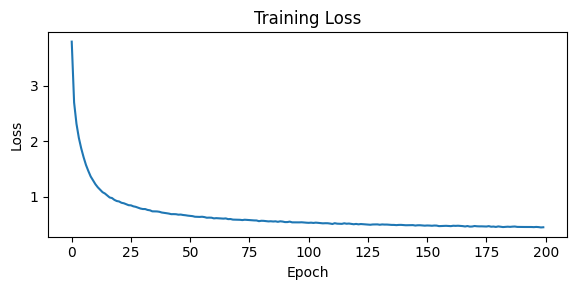

In [41]:
encoder = TransformerEncoder(
    len(src_vocab), D_MODEL, D_FF, NUM_HEADS, NUM_LAYERS, DROPOUT)
decoder = TransformerDecoder(
    len(tgt_vocab), D_MODEL, D_FF, NUM_HEADS, NUM_LAYERS, DROPOUT)
net_scratch = EncoderDecoder(encoder, decoder)

train_model(net_scratch, train_iter, LR, NUM_EPOCHS, tgt_vocab, device)

## 3.8 推理 & BLEU

In [42]:
evaluate(net_scratch, '源代码实现')

=== 源代码实现 ===
go .             => va te faire foutre !  BLEU=0.000  (ref: va !)
i lost .         => j'ai perdu .          BLEU=1.000  (ref: j'ai perdu .)
he's calm .      => il est calme .        BLEU=1.000  (ref: il est calme .)
i'm home .       => je suis à la maison .  BLEU=0.473  (ref: je suis chez moi .)


---
# 4. 实现 B — 简洁实现（nn.Transformer）

PyTorch 内置了 `nn.Transformer`，封装了上面手写的全部组件。
只需 **一个类、约 30 行代码** 即可完成相同的模型。

### 源代码实现 vs 简洁实现的对应关系

| 源代码实现 | nn.Transformer |
|---|---|
| `masked_softmax(scores, valid_lens)` | `src_key_padding_mask`（bool 掩码，`True` = 忽略） |
| Decoder 中手写的因果遮蔽 | `nn.Transformer.generate_square_subsequent_mask()` |
| `MultiHeadAttention` | `nn.MultiheadAttention`（内置于 TransformerEncoderLayer） |
| `EncoderBlock` / `DecoderBlock` | `nn.TransformerEncoderLayer` / `nn.TransformerDecoderLayer` |
| `TransformerEncoder` / `TransformerDecoder` | 全部封装在 `nn.Transformer` 中 |
| 推理时手写 KV-cache | 无内置 KV-cache，每步传入完整已生成序列 |

In [43]:
class ConciseTransformer(nn.Module):
    """
    基于 nn.Transformer 的简洁实现。
    forward 接口与源代码实现一致：(src, tgt, src_valid_lens) → (logits, None)
    """
    def __init__(self, src_vocab_size, tgt_vocab_size,
                 d_model, nhead, num_layers, d_ff, dropout):
        super().__init__()
        self.d_model = d_model
        self.src_embed = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embed = nn.Embedding(tgt_vocab_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, dropout)
        # 核心：一行搞定 Encoder + Decoder + Attention + FFN
        self.transformer = nn.Transformer(
            d_model=d_model, nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=d_ff, dropout=dropout,
            batch_first=True)  # 使用 (batch, seq, d_model) 格式
        # 关闭 nested tensor 快速路径（避免推理时 memory 形状不匹配）
        self.transformer.encoder.enable_nested_tensor = False
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)

    def _pad_mask(self, seq_len, valid_lens):
        """将 valid_lens 转为 bool 掩码。True = 忽略该位置。"""
        return torch.arange(seq_len, device=valid_lens.device) >= valid_lens.unsqueeze(1)

    def forward(self, src, tgt, src_valid_lens):
        # ① 构造掩码
        src_pad = self._pad_mask(src.size(1), src_valid_lens)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(
            tgt.size(1)).to(tgt.device)  # 因果遮蔽（上三角 -inf）

        # ② 嵌入 + 位置编码
        src_emb = self.pos_enc(self.src_embed(src) * math.sqrt(self.d_model))
        tgt_emb = self.pos_enc(self.tgt_embed(tgt) * math.sqrt(self.d_model))

        # ③ Transformer 前向传播
        out = self.transformer(
            src_emb, tgt_emb,
            tgt_mask=tgt_mask,                   # Decoder 因果遮蔽
            src_key_padding_mask=src_pad,         # Encoder padding 遮蔽
            memory_key_padding_mask=src_pad)       # Cross-Attention padding 遮蔽

        return self.fc_out(out), None  # 返回 (logits, None) 兼容 train_model

## 4.1 训练简洁实现

Epoch   1, Loss: 3.9338
Epoch  20, Loss: 1.1375
Epoch  40, Loss: 0.8038
Epoch  60, Loss: 0.6753
Epoch  80, Loss: 0.6026
Epoch 100, Loss: 0.5585
Epoch 120, Loss: 0.5315
Epoch 140, Loss: 0.5098
Epoch 160, Loss: 0.4904
Epoch 180, Loss: 0.4819
Epoch 200, Loss: 0.4692


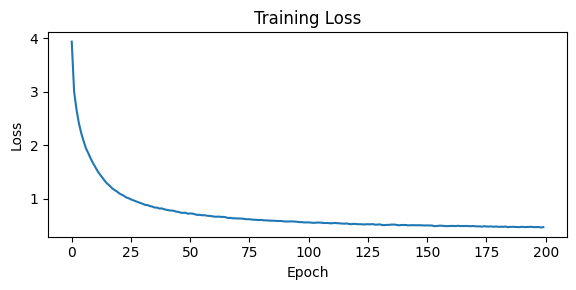

In [44]:
net_concise = ConciseTransformer(
    len(src_vocab), len(tgt_vocab),
    D_MODEL, NUM_HEADS, NUM_LAYERS, D_FF, DROPOUT)

train_model(net_concise, train_iter, LR, NUM_EPOCHS, tgt_vocab, device)

## 4.2 推理 & BLEU

In [45]:
evaluate(net_concise, '简洁实现')

=== 简洁实现 ===
go .             => pars !                BLEU=0.000  (ref: va !)
i lost .         => j'ai perdu .          BLEU=1.000  (ref: j'ai perdu .)
he's calm .      => il est calme .        BLEU=1.000  (ref: il est calme .)
i'm home .       => je suis chez moi .    BLEU=1.000  (ref: je suis chez moi .)


---
# 附录

## A. Encoder-Decoder Attention 可视化

观察源代码实现中，Decoder 在翻译时"看向"源句的哪些词。

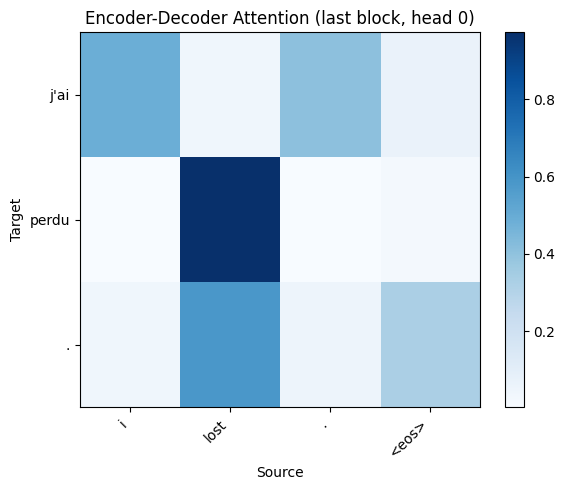

In [46]:
def show_attention_weights(attention, src_tokens, tgt_tokens, title=''):
    weights = attention.detach().cpu().numpy()
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(weights, cmap='Blues', aspect='auto')
    ax.set_xticks(range(len(src_tokens)))
    ax.set_xticklabels(src_tokens, rotation=45, ha='right')
    ax.set_yticks(range(len(tgt_tokens)))
    ax.set_yticklabels(tgt_tokens)
    ax.set_xlabel('Source'); ax.set_ylabel('Target')
    if title: ax.set_title(title)
    fig.colorbar(im, ax=ax)
    plt.tight_layout(); plt.show()

# 用源代码实现做一次推理，收集 attention 权重
test_src = 'i lost .'
src_tokens = test_src.split() + ['<eos>']

net_scratch.eval()
_src = torch.tensor(src_vocab[src_tokens], device=device).unsqueeze(0)
_len = torch.tensor([len(src_tokens)], device=device)
with torch.no_grad():
    enc_out = net_scratch.encoder(_src, _len)
state = net_scratch.decoder.init_state(enc_out, _len)

dec_in = torch.tensor([[tgt_vocab[Vocab.BOS]]], device=device)
tgt_out, attn_all = [], []
for _ in range(NUM_STEPS):
    with torch.no_grad():
        Y, state = net_scratch.decoder(dec_in, state)
    nid = Y.argmax(dim=-1)[:, -1:].item()
    if nid == tgt_vocab[Vocab.EOS]: break
    tgt_out.append(tgt_vocab.idx_to_token[nid])
    w = net_scratch.decoder.blocks[-1].attention2.attention.attention_weights
    attn_all.append(w[0, 0, :len(src_tokens)].detach().cpu())
    dec_in = torch.tensor([[nid]], device=device)

if attn_all:
    show_attention_weights(
        torch.stack(attn_all), src_tokens, tgt_out,
        title='Encoder-Decoder Attention (last block, head 0)')
else:
    print('No output tokens generated.')

## B. Positional Encoding 可视化

不同维度的正弦/余弦波频率不同——低维变化快，高维变化慢。

/tmp/ipython-input-1749750080.py:11: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/tmp/ipython-input-1749750080.py:11: UserWarning: Glyph 21069 (\N{CJK UNIFIED IDEOGRAPH-524D}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/tmp/ipython-input-1749750080.py:11: UserWarning: Glyph 32500 (\N{CJK UNIFIED IDEOGRAPH-7EF4}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/tmp/ipython-input-1749750080.py:11: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21069 (\N{CJK UNIFIED IDEOGRAPH-524D}) missing from fo

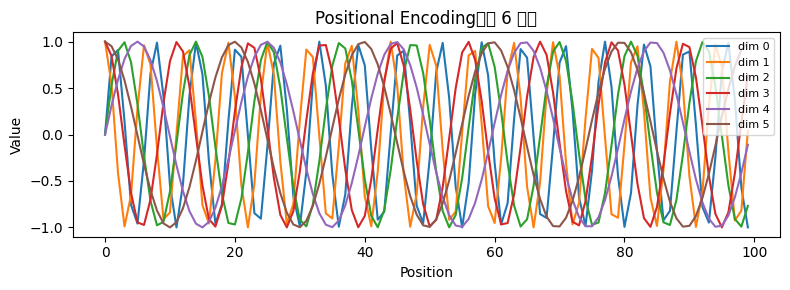

In [47]:
pe = PositionalEncoding(D_MODEL, 0)
X = pe(torch.zeros(1, 100, D_MODEL))
pe_data = X[0].detach().numpy()

fig, ax = plt.subplots(figsize=(8, 3))
for i in range(6):
    ax.plot(pe_data[:, i], label=f'dim {i}')
ax.set_xlabel('Position'); ax.set_ylabel('Value')
ax.set_title('Positional Encoding（前 6 维）')
ax.legend(loc='upper right', fontsize=8)
plt.tight_layout(); plt.show()

## C. 组件维度检查

In [48]:
batch, seq = 2, 8
X = torch.randn(batch, seq, D_MODEL)

mha = MultiHeadAttention(D_MODEL, NUM_HEADS, DROPOUT); mha.eval()
print(f'MultiHeadAttention: {X.shape} → {mha(X, X, X).shape}')

ffn = PositionWiseFFN(D_MODEL, D_FF)
print(f'PositionWiseFFN:    {X.shape} → {ffn(X).shape}')

an = AddNorm(D_MODEL, DROPOUT); an.eval()
print(f'AddNorm:            {X.shape} → {an(X, X).shape}')

enc_blk = EncoderBlock(D_MODEL, D_FF, NUM_HEADS, DROPOUT); enc_blk.eval()
print(f'EncoderBlock:       {X.shape} → {enc_blk(X, None).shape}')

MultiHeadAttention: torch.Size([2, 8, 32]) → torch.Size([2, 8, 32])
PositionWiseFFN:    torch.Size([2, 8, 32]) → torch.Size([2, 8, 32])
AddNorm:            torch.Size([2, 8, 32]) → torch.Size([2, 8, 32])
EncoderBlock:       torch.Size([2, 8, 32]) → torch.Size([2, 8, 32])
